# CLASIFICACIÓN DE IMÁGENES HISTOPATOLÓGICAS DE CÁNCER DE MAMA USANDO REDES NEURONALES CONVOLUCIONALES

## Artificial Neural Networks - 2020-2

* Gantiva, S esgantivar@unal.edu.co
* Carrillo, E eccarrilloe@unal.edu.co
* Garzón, E egarzonv@unal.edu.co
* Velásquez, D arvelasqueza@unal.edu.co

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copy h5py datasets

In [2]:
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_40PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_100PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_200PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_400PX_96.hdf5' .

Install additional libraries

In [3]:
!pip install fuel -q

     |████████████████████████████████| 194kB 13.6MB/s 


Load libraries

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from tqdm import tqdm
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [3]:
from fuel.datasets import H5PYDataset

In [4]:
import matplotlib.pyplot as plt
import itertools

## Utils Functions

In [81]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

In [5]:
def plot_metric(history, metric, init=0, title='Training and validation', path='/notebooks/storage', save=False, ext='pdf'):
  train_metrics = history[metric][init:]
  val_metrics = history['val_'+metric][init:]
  epochs = [i for i in range(init + 1, len(train_metrics) + 1 + init)]
  plt.style.use("seaborn")
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  if save:
    plt.savefig(f"{path}/{title}.{ext}")
  plt.show()

In [6]:
def save_history(history, name, path='/notebooks/storage/histories'):
    '''
        history: Generated from training process
        name: Name to persist the history on storage
    '''
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = f'{path}/{name}.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

In [7]:
def load_history(name, path='/notebooks/storage/histories'):    
    '''
        name: Name to find and load history
    '''
    return pd.read_json(f'{path}/{name}.json')

In [8]:
def save_model_utils(model, path='/notebooks/storage/models'):
    model.save(f'{path}/{model.name}.h5')
    print(f'saved as: {model.name}')

In [9]:
def load_model_utils(name, path='/notebooks/storage/models'):
    print(f'{path}/{name}.h5')
    return load_model(f'{path}/{name}.h5')

In [10]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        save=False,
                        path='/content',
                        ext='pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
      plt.savefig(f"{path}/{title}.{ext}")

## Proposed Model Artificial Neural Network

In [ ]:
lr = 0.0001

In [ ]:
for px in [40]:
  model = Sequential(name=f'{px}PX_96_shallow')
  model.add(Conv2D(input_shape=(96,96,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(4,4),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=2, activation="softmax"))

  model.summary()

  earlyStopping = ReturnBestEarlyStopping(monitor='val_accuracy', 
                                          patience=50, 
                                          verbose=1, 
                                          mode='max', 
                                          restore_best_weights=True)
  callback_list = [earlyStopping]

  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_train = tf.keras.utils.to_categorical(y_train, 2)
  print('train', x_train.shape, y_train.shape)

  x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_dev = tf.keras.utils.to_categorical(y_dev, 2)
  print('dev', x_dev.shape, y_dev.shape)

  history = model.fit(x_train, 
                      y_train, 
                      epochs=50,
                      verbose=1,
                      batch_size=64, 
                      callbacks=callback_list,
                      validation_data=(x_dev, y_dev))
  
  save_model_utils(model, path='/content')
  save_history(history, f'{px}PX_shallow', path='/content')

  x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_true = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_test = tf.keras.utils.to_categorical(y_test, 2)
  print('test', x_test.shape, y_test.shape)

  score_train = model.evaluate(x_train, y_train, verbose=0)
  print('train', score_train)
  score_dev = model.evaluate(x_dev, y_dev, verbose=0)
  print('dev', score_dev)
  score_test = model.evaluate(x_test, y_test, verbose=0)
  print('test', score_test)

Model: "40PX_96_shallow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 64)        65600     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 128)   

In [ ]:
!mv '/content/40PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/100PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/200PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/400PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'

!mv '/content/40PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/100PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/200PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/400PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'

### Evaluate

In [ ]:
PX = 40

In [ ]:
model_load = load_model_utils(f'{PX}PX_96_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models')

/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models/40PX_96_shallow.h5


In [ ]:
x_test = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
y_test = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_true = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_test = tf.keras.utils.to_categorical(y_test, 2)
x_test.shape, y_test.shape, y_true.shape

((598, 96, 96, 3), (598, 2), (598,))

In [ ]:
y_pred = model_load.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred)
cm

array([[107,  80],
       [ 25, 386]])

In [ ]:
ext = 'png'

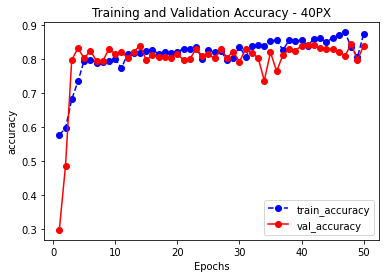

In [ ]:
plot_metric(load_history(f'{PX}PX_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'), 
            'accuracy', 
            title=f'Training and Validation Accuracy - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)

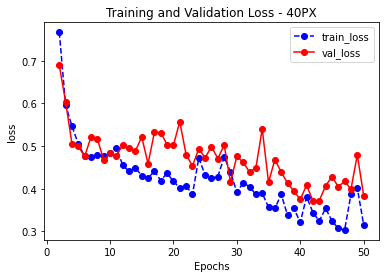

In [ ]:
plot_metric(load_history(f'{PX}PX_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'), 
            'loss', 
            init=1,
            title=f'Training and Validation Loss - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)

In [ ]:
cm_plot_labels = ['bening','malignant']

In [ ]:
cm_plot_labels = ['bening','malignant']
plot_confusion_matrix(cm=cm, 
                      classes=cm_plot_labels, 
                      title=f'Confusion Matrix {PX}PX', 
                      save=True,
                      ext=ext)

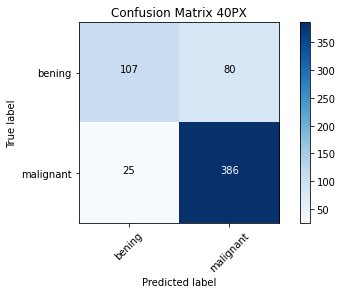

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=cm_plot_labels, 
                      title=f'Confusion Matrix {PX}PX', 
                      save=True,
                      ext=ext)

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Example of Use PCA to extract features on MNIST

In [56]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2])) / 255.0
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2])) / 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [57]:
pca = PCA(n_components=10)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

x_train_pca.shape, x_test_pca.shape

((60000, 10), (10000, 10))

In [59]:
model = Sequential()
model.add(Dense(units=10,activation="relu"))
#model.add(Dropout(0.5))
#model.add(Dense(units=100,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

In [60]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_pca_mnist = model.fit(
    x=x_train_pca,
    y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(x_test_pca, y_test)
)

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 1.5987 - accuracy: 0.4716 - val_loss: 1.0212 - val_accuracy: 0.6718
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.8514 - accuracy: 0.7265 - val_loss: 0.7188 - val_accuracy: 0.7710
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6761 - accuracy: 0.7796 - val_loss: 0.6235 - val_accuracy: 0.7964
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6088 - accuracy: 0.7995 - val_loss: 0.5797 - val_accuracy: 0.8098
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.5736 - accuracy: 0.8115 - val_loss: 0.5538 - val_accuracy: 0.8188
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.5521 - accuracy: 0.8184 - val_loss: 0.5374 - val_accuracy: 0.8268
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.5382 - accuracy: 0.8237 - val_loss: 0.5282 - val_accuracy: 0.8276
Epoch 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


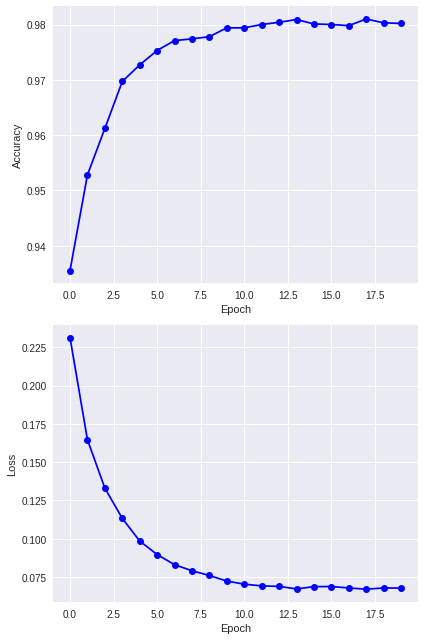

In [49]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(history_pca_mnist.history["val_accuracy"], "-ob")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history_pca_mnist.history["val_loss"], "-ob")
ax2.set_ylabel("Loss")
#ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## PCA on Breakhis

In [65]:
px = 40
x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_train = tf.keras.utils.to_categorical(y_train, 2)
print('train', x_train.shape, y_train.shape)

x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_dev = tf.keras.utils.to_categorical(y_dev, 2)
print('dev', x_dev.shape, y_dev.shape)

train (998, 96, 96, 3) (998, 2)
dev (399, 96, 96, 3) (399, 2)


In [77]:
pca_40x_r = PCA(n_components=100)
pca_40x_g = PCA(n_components=100)
pca_40x_b = PCA(n_components=100)

In [76]:
x_train_r = (x_train[:,:,:,0]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2])
x_train_g = (x_train[:,:,:,1]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2])
x_train_b = (x_train[:,:,:,2]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2])

x_dev_r  = (x_dev[:,:,:,0]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2])
x_dev_g  = (x_dev[:,:,:,1]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2])
x_dev_b  = (x_dev[:,:,:,2]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2])

x_train_r.shape, x_train_g.shape, x_train_b.shape, x_dev_r.shape, x_dev_g.shape, x_dev_b.shape

((998, 9216), (998, 9216), (998, 9216), (399, 9216), (399, 9216), (399, 9216))

In [78]:
pca_40x_r.fit(x_train_r)
pca_40x_g.fit(x_train_g)
pca_40x_b.fit(x_train_b)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [96]:
x_train_pca = np.concatenate((pca_40x_r.transform(x_train_r), pca_40x_g.transform(x_train_g), pca_40x_b.transform(x_train_b)), axis=1)
x_dev_pca = np.concatenate((pca_40x_r.transform(x_dev_r), pca_40x_g.transform(x_dev_g), pca_40x_b.transform(x_dev_b)), axis=1)

x_train_pca.shape, x_dev_pca.shape

((998, 300), (399, 300))

In [16]:
def perceptron(units=300):
  model = Sequential()
  model.add(Dense(units=units,activation="relu"))
  # model.add(Dropout(0.5))
  # model.add(Dense(units=100,activation="relu"))
  model.add(Dense(units=2, activation="softmax"))
  return model

In [109]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [110]:
history_pca_mnist = model.fit(
    x=x_train_pca,
    y=y_train,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_data=(x_dev_pca, y_dev)
)

Epoch 1/100
8/8 [==============================] - 0s 19ms/step - loss: 88.9103 - accuracy: 0.6212 - val_loss: 30.9616 - val_accuracy: 0.8120
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 34.3249 - accuracy: 0.7886 - val_loss: 32.5272 - val_accuracy: 0.7419
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 15.1538 - accuracy: 0.8527 - val_loss: 15.9663 - val_accuracy: 0.7744
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 6.7226 - accuracy: 0.8737 - val_loss: 13.3334 - val_accuracy: 0.7744
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 3.5811 - accuracy: 0.9038 - val_loss: 11.8117 - val_accuracy: 0.8045
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 1.7374 - accuracy: 0.9429 - val_loss: 10.1697 - val_accuracy: 0.8095
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4506 - accuracy: 0.9729 - val_loss: 10.0312 - val_accuracy: 0.8321
Epoch 8/100
8/8 

In [21]:
results = {}
for px in [40, 100, 200, 400]:
  x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_train = tf.keras.utils.to_categorical(y_train, 2)

  x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_dev = tf.keras.utils.to_categorical(y_dev, 2)

  x_train_r = (x_train[:,:,:,0]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2]) / 255.0
  x_train_g = (x_train[:,:,:,1]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2]) / 255.0
  x_train_b = (x_train[:,:,:,2]).reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2]) / 255.0

  x_dev_r  = (x_dev[:,:,:,0]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2]) / 255.0
  x_dev_g  = (x_dev[:,:,:,1]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2]) / 255.0
  x_dev_b  = (x_dev[:,:,:,2]).reshape(x_dev.shape[0],x_dev.shape[1] * x_dev.shape[2]) / 255.0
  results[f'{px}'] = {
      'train': [],
      'dev': [],
      'test': []
  }
  for cmpt in [2,4,8,16,32,64,128]:
    pca_r = PCA(n_components=cmpt)
    pca_g = PCA(n_components=cmpt)
    pca_b = PCA(n_components=cmpt)

    pca_r.fit(x_train_r)
    pca_g.fit(x_train_g)
    pca_b.fit(x_train_b)

    x_train_pca = np.concatenate((pca_r.transform(x_train_r), pca_g.transform(x_train_g), pca_b.transform(x_train_b)), axis=1)
    x_dev_pca = np.concatenate((pca_r.transform(x_dev_r), pca_g.transform(x_dev_g), pca_b.transform(x_dev_b)), axis=1)

    model = perceptron(cmpt)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    earlyStopping = ReturnBestEarlyStopping(monitor='val_accuracy', 
                                          patience=50, 
                                          verbose=1, 
                                          mode='max', 
                                          restore_best_weights=True)
    callback_list = [earlyStopping]
    history = model.fit(
        x=x_train_pca,
        y=y_train,
        batch_size=128,
        epochs=50,
        callbacks=callback_list,
        verbose=0,
        validation_data=(x_dev_pca, y_dev)
    )

    x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
    y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
    y_true = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
    y_test = tf.keras.utils.to_categorical(y_test, 2)

    x_test_r = (x_test[:,:,:,0]).reshape(x_test.shape[0],x_test.shape[1] * x_test.shape[2]) / 255.0
    x_test_g = (x_test[:,:,:,1]).reshape(x_test.shape[0],x_test.shape[1] * x_test.shape[2]) / 255.0
    x_test_b = (x_test[:,:,:,2]).reshape(x_test.shape[0],x_test.shape[1] * x_test.shape[2]) / 255.0

    x_test_pca = np.concatenate((pca_r.transform(x_test_r), pca_g.transform(x_test_g), pca_b.transform(x_test_b)), axis=1)
    
    score_train = model.evaluate(x_train_pca, y_train, verbose=0)
    score_dev = model.evaluate(x_dev_pca, y_dev, verbose=0)
    score_test = model.evaluate(x_test_pca, y_test, verbose=0)

    results[f'{px}']['train'].append(score_train[1])
    results[f'{px}']['dev'].append(score_dev[1])
    results[f'{px}']['test'].append(score_test[1])

Restoring model weights from the end of the best epoch.
px 40 pca 2 train [0.6452270746231079, 0.671342670917511]
px 40 pca 2 dev [0.6177812814712524, 0.6741854548454285]
px 40 pca 2 test [0.6244971752166748, 0.6655518412590027]
Restoring model weights from the end of the best epoch.
px 40 pca 4 train [0.5381472110748291, 0.7595190405845642]
px 40 pca 4 dev [0.5383269786834717, 0.7268170714378357]
px 40 pca 4 test [0.5531472563743591, 0.7441471815109253]
Restoring model weights from the end of the best epoch.
px 40 pca 8 train [0.4266926348209381, 0.8086172342300415]
px 40 pca 8 dev [0.44912102818489075, 0.8070175647735596]
px 40 pca 8 test [0.47052595019340515, 0.7926421165466309]
Restoring model weights from the end of the best epoch.
px 40 pca 16 train [0.31583791971206665, 0.8717435002326965]
px 40 pca 16 dev [0.35909533500671387, 0.8496240377426147]
px 40 pca 16 test [0.37984904646873474, 0.8428093791007996]
Restoring model weights from the end of the best epoch.
px 40 pca 32 trai

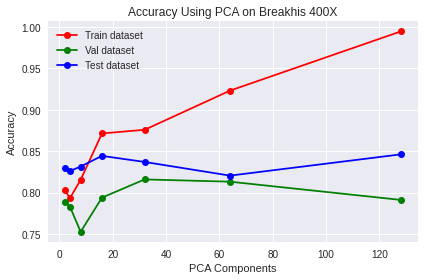

In [67]:
px = f'{400}'
plt.style.use("seaborn")
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

ax1.plot([2,4,8,16,32,64,128],results[px]['train'], "-or", label='Train dataset')
ax1.plot([2,4,8,16,32,64,128],results[px]['dev'], "-og", label='Val dataset')
ax1.plot([2,4,8,16,32,64,128],results[px]['test'], "-ob", label='Test dataset')
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("PCA Components")
ax1.legend()
'''
ax2.plot(history_pca_mnist.history["val_loss"], "-ob")
ax2.set_ylabel("Loss")
#ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
'''
plt.title(f'Accuracy Using PCA on Breakhis {px}X')
plt.tight_layout()
plt.savefig(f"/content/acc-pca-{px}.png")
plt.show()

In [63]:
px = f'{400}'
comps = [2 ** i for i in range(1, 8)]

for idx, val in enumerate(comps):
  print(val , '&', round(results[px]['train'][idx] * 100, 2), '&', round(results[px]['dev'][idx] * 100, 2), '&',round(results[px]['test'][idx] * 100, 2), '\\\\ \hline')

2 & 80.33 & 78.85 & 82.97 \\ \hline
4 & 79.34 & 78.3 & 82.6 \\ \hline
8 & 81.54 & 75.27 & 83.15 \\ \hline
16 & 87.14 & 79.4 & 84.43 \\ \hline
32 & 87.58 & 81.59 & 83.7 \\ \hline
64 & 92.31 & 81.32 & 82.05 \\ \hline
128 & 99.45 & 79.12 & 84.62 \\ \hline


## Transfer Learning

In [16]:
model = MobileNetV2()
model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

In [89]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_breakhis')
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[len(model.layers) - 4:]:
    layer.trainable = True
earlyStopping = ReturnBestEarlyStopping(monitor='val_accuracy', 
                                          patience=50, 
                                          verbose=1, 
                                          mode='max', 
                                          restore_best_weights=True)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy']
              )

In [95]:
px = 40
x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_train = tf.keras.utils.to_categorical(y_train, 2)

x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_dev = tf.keras.utils.to_categorical(y_dev, 2)

x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [96]:
x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape

((998, 96, 96, 3),
 (998, 2),
 (399, 96, 96, 3),
 (399, 2),
 (598, 96, 96, 3),
 (598, 2))

In [97]:
x_train_p = []
for i in tqdm(range(x_train.shape[0])):
  x_train_p.append(preprocess_input(x_train[i]))
x_train_p = np.array(x_train_p)

x_dev_p = []
for i in tqdm(range(x_dev.shape[0])):
  x_dev_p.append(preprocess_input(x_dev[i]))

x_dev_p = np.array(x_dev_p)

x_test_p = []
for i in tqdm(range(x_test.shape[0])):
  x_test_p.append(preprocess_input(x_test[i]))

x_test_p = np.array(x_test_p)

x_train_p.shape, y_train.shape, x_dev_p.shape, y_dev.shape, x_test_p.shape, y_test.shape

100%|██████████| 598/598 [00:00<00:00, 19250.41it/s]


((998, 96, 96, 3),
 (998, 2),
 (399, 96, 96, 3),
 (399, 2),
 (598, 96, 96, 3),
 (598, 2))

In [98]:
model.fit(
    x_train_p,
    y_train,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(x_dev_p, y_dev),
    callbacks=[earlyStopping]
    )
score_train = model.evaluate(x_train_p, y_train, verbose=0)
print('train', score_train)
score_dev = model.evaluate(x_dev_p, y_dev, verbose=0)
print('dev', score_dev)
score_test = model.evaluate(x_test_p, y_test, verbose=0)
print('test', score_test)

Restoring model weights from the end of the best epoch.

Epoch 58: early stopping
train [0.0005232167313806713, 1.0]
dev [0.5463960766792297, 0.9047619104385376]
test [0.4883361756801605, 0.8979933261871338]


In [109]:
results = {}
for px in [40, 100, 200, 400]:
  x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_train = tf.keras.utils.to_categorical(y_train, 2)

  x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_dev = tf.keras.utils.to_categorical(y_dev, 2)

  x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_test = tf.keras.utils.to_categorical(y_test, 2)

  x_train_p = []
  for i in tqdm(range(x_train.shape[0])):
    x_train_p.append(preprocess_input(x_train[i]))
  x_train_p = np.array(x_train_p)

  x_dev_p = []
  for i in tqdm(range(x_dev.shape[0])):
    x_dev_p.append(preprocess_input(x_dev[i]))
  x_dev_p = np.array(x_dev_p)

  x_test_p = []
  for i in tqdm(range(x_test.shape[0])):
    x_test_p.append(preprocess_input(x_test[i]))
  x_test_p = np.array(x_test_p)

  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(2048, activation='relu')(x)
  preds = Dense(2, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=preds, name=f'mbnet_{px}X_breakhis')
  for layer in model.layers:
      layer.trainable = False
  for layer in model.layers[len(model.layers) - 4:]:
      layer.trainable = True
  earlyStopping = ReturnBestEarlyStopping(monitor='val_accuracy', 
                                            patience=100, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=True)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=['accuracy']
                )
  history = model.fit(
    x_train_p,
    y_train,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(x_dev_p, y_dev),
    callbacks=[earlyStopping]
    )
  save_model_utils(model, path='/content')
  save_history(history, f'{px}X_TL', path='/content')

  score_train = model.evaluate(x_train_p, y_train, verbose=0)
  score_dev = model.evaluate(x_dev_p, y_dev, verbose=0)
  score_test = model.evaluate(x_test_p, y_test, verbose=0)

  results[f'{px}'] = {
      'train': score_train[1],
      'dev': score_dev[1],
      'test': score_test[1]
  }
results

100%|██████████| 598/598 [00:00<00:00, 18803.74it/s]


Restoring model weights from the end of the best epoch.
saved as: mbnet_40X_breakhis


100%|██████████| 624/624 [00:00<00:00, 18881.54it/s]


Restoring model weights from the end of the best epoch.
saved as: mbnet_100X_breakhis


100%|██████████| 603/603 [00:00<00:00, 20915.16it/s]


Restoring model weights from the end of the best epoch.
saved as: mbnet_200X_breakhis


100%|██████████| 546/546 [00:00<00:00, 19937.58it/s]


Restoring model weights from the end of the best epoch.
saved as: mbnet_400X_breakhis


{'100': {'dev': 0.879807710647583, 'test': 0.8605769276618958, 'train': 1.0},
 '200': {'dev': 0.9154228568077087, 'test': 0.8855721354484558, 'train': 1.0},
 '40': {'dev': 0.9122806787490845, 'test': 0.9013378024101257, 'train': 1.0},
 '400': {'dev': 0.8653846383094788, 'test': 0.860805869102478, 'train': 1.0}}

In [ ]:
results['40']

In [110]:
!cp "/content/mbnet_40X_breakhis.h5" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/mbnet_100X_breakhis.h5" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/mbnet_200X_breakhis.h5" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/mbnet_400X_breakhis.h5" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"

In [111]:
!cp "/content/40X_TL.json" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/100X_TL.json" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/200X_TL.json" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"
!cp "/content/400X_TL.json" "/content/drive/Shareddrives/Redes Neuronales/Proyecto - RN/TL"

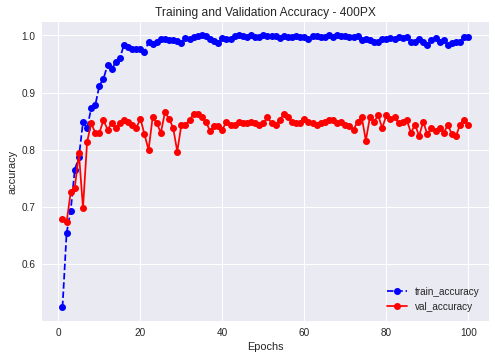

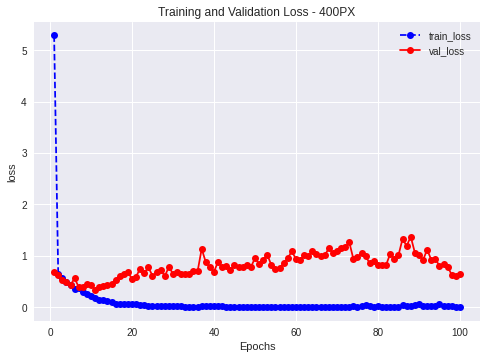

In [127]:
PX = 400
ext = 'pdf'
plot_metric(load_history(f'{PX}X_TL', path='/content/'), 
            'accuracy', 
            title=f'Training and Validation Accuracy - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)
plot_metric(load_history(f'{PX}X_TL', path='/content/'), 
            'loss', 
            title=f'Training and Validation Loss - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)

In [51]:
px = 400
ext='pdf'

In [52]:
model_load = load_model_utils(f'mbnet_{px}X_breakhis', path='/content')

/content/mbnet_400X_breakhis.h5


In [53]:
x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_train = tf.keras.utils.to_categorical(y_train, 2)

x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_dev = tf.keras.utils.to_categorical(y_dev, 2)

In [54]:
x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_true = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [55]:
x_train_p = []
for i in tqdm(range(x_train.shape[0])):
  x_train_p.append(preprocess_input(x_train[i]))
x_train_p = np.array(x_train_p)

x_dev_p = []
for i in tqdm(range(x_dev.shape[0])):
  x_dev_p.append(preprocess_input(x_dev[i]))
x_dev_p = np.array(x_dev_p)

x_test_p = []
for i in tqdm(range(x_test.shape[0])):
  x_test_p.append(preprocess_input(x_test[i]))
x_test_p = np.array(x_test_p)

100%|██████████| 546/546 [00:00<00:00, 19719.89it/s]


In [56]:
model_load.evaluate(x_train_p, y_train)

29/29 [==============================] - 1s 18ms/step - loss: 0.0013 - accuracy: 1.0000


[0.0013466947712004185, 1.0]

In [57]:
model_load.evaluate(x_dev_p, y_dev)

12/12 [==============================] - 0s 19ms/step - loss: 0.6764 - accuracy: 0.8654


[0.6763752102851868, 0.8653846383094788]

In [58]:
model_load.evaluate(x_test_p, y_test)

18/18 [==============================] - 0s 15ms/step - loss: 0.5992 - accuracy: 0.8608


[0.5992178916931152, 0.860805869102478]

In [59]:
y_pred = model_load.predict(x_test_p)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred)
cm

array([[114,  47],
       [ 29, 356]])

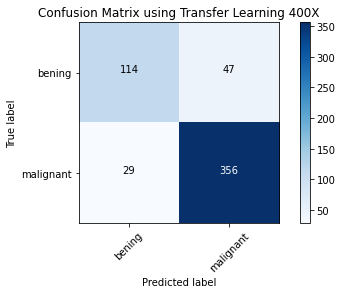

In [60]:
cm_plot_labels = ['bening','malignant']
plot_confusion_matrix(cm=cm, 
                      classes=cm_plot_labels, 
                      title=f'Confusion Matrix using Transfer Learning {px}X', 
                      save=True,
                      ext=ext)